# K-means Clustering Analysis with Python
## Overview
This notebook guides you through the process of loading and preprocessing data, applying K-means clustering, and visualizing the results using Python. The analysis includes clustering customers based on their tenure and monthly charges using Min-Max scaled and Standard scaled data.

## Step 1: Importing Required Libraries
First, import all the necessary libraries and modules that will be used for data processing, clustering, and visualization.

In [12]:
import os
import sys
import json
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score


## Step 2: Set Up Paths and Ensure Utility Modules are Accessible
Here, we ensure that our custom utility modules can be accessed by setting up the correct paths. This step is important to make sure the script can locate and import necessary functions from other parts of your project.

In [13]:
# Ensure the utils module can be found
notebook_dir = os.path.dirname(os.path.abspath(''))
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
utils_path = os.path.join(project_root, 'utils')

print(f"Notebook directory: {notebook_dir}")
print(f"Project root: {project_root}")
print(f"Utils path: {utils_path}")

if utils_path not in sys.path:
    sys.path.append(utils_path)

try:
    from data_loader import load_data
    from data_cleaner import clean_data
    from handle_missing_and_encode import handle_missing_and_encode
except ImportError as e:
    print(f"Error importing module: {e}")
    sys.exit(1)


Notebook directory: C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main\notebooks
Project root: C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main
Utils path: C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main\utils


## Step 3: Load Configuration and Set Up Paths
In this step, we load configuration settings from `config.json` and convert relative paths to absolute paths to ensure that the correct data files are accessed during the analysis.

In [14]:
# Load configuration
config_path = os.path.join(os.path.dirname(os.path.abspath('')), '..', 'config.json')
print(f"Config path: {config_path}")
with open(config_path, 'r') as f:
    config = json.load(f)

# Convert relative paths to absolute paths
project_root = os.path.dirname(os.path.dirname(os.path.abspath('')))
raw_data_path = os.path.join(project_root, config['raw_data_path'])
interim_cleaned_data_path = os.path.join(project_root, config['interim_cleaned_data_path'])
preprocessed_data_path = os.path.join(project_root, config['preprocessed_data_path'])
standard_scaled_data_path = os.path.join(project_root, 'data_preparation/scaling_techniques/standard_scaled_dataset.csv')
min_max_scaled_data_path = os.path.join(project_root, 'data_preparation/scaling_techniques/min_max_scaled_dataset.csv')

print(f"Raw data path (absolute): {raw_data_path}")
print(f"Interim cleaned data path (absolute): {interim_cleaned_data_path}")
print(f"Preprocessed data path (absolute): {preprocessed_data_path}")
print(f"Standard scaled data path (absolute): {standard_scaled_data_path}")
print(f"Min-Max scaled data path (absolute): {min_max_scaled_data_path}")


Config path: C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main\notebooks\..\config.json
Raw data path (absolute): C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main\data/raw/Dataset (ATS)-1.csv
Interim cleaned data path (absolute): C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main\data/interim/cleaned_dataset.csv
Preprocessed data path (absolute): C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main\Data_Preparation/preprocessed_dataset/cleaned_dataset.csv
Standard scaled data path (absolute): C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main\data_preparation/scaling_techniques/standard_scaled_dataset.csv
Min-Max scaled data path (absolute): C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main\data_preparation/scaling_techniques/min_max_scaled_dataset.csv


## Step 4: Load the Preprocessed Data
Load the preprocessed datasets (both Min-Max scaled and Standard scaled) to prepare them for clustering.

In [15]:
# Load the min-max scaled data
df_min_max_scaled = pd.read_csv(min_max_scaled_data_path)
print(f"Min-Max scaled data loaded successfully from {min_max_scaled_data_path}")
df_standard_scaled = pd.read_csv(standard_scaled_data_path)
print(f"Standard scaled data loaded successfully from {standard_scaled_data_path}")

# Example of printing the first few rows to verify
print("Standard Scaled Data:")
print(df_standard_scaled.head())

print("Min-Max Scaled Data:")
print(df_min_max_scaled.head())


Min-Max scaled data loaded successfully from C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main\data_preparation/scaling_techniques/min_max_scaled_dataset.csv
Standard scaled data loaded successfully from C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main\data_preparation/scaling_techniques/standard_scaled_dataset.csv
Standard Scaled Data:
   SeniorCitizen    tenure  MonthlyCharges  gender_Female  gender_Male  \
0      -0.439916 -1.277445       -1.160323       1.009559    -1.009559   
1      -0.439916  0.066327       -0.259629      -0.990532     0.990532   
2      -0.439916 -1.236724       -0.362660      -0.990532     0.990532   
3      -0.439916  0.514251       -0.746535      -0.990532     0.990532   
4      -0.439916 -1.236724        0.197365       1.009559    -1.009559   

   Dependents_No  Dependents_Yes  PhoneService_No  PhoneService_Yes  \
0       0.654012       -0.654012         3.054010         -3.054010   
1       0.654012       -0.654012        -0.3274

## Step 5: Apply K-means Clustering and Visualize Clusters
Define a function to apply K-means clustering to the dataset and generate visualizations of the clusters. This function will also save the visualizations to a specified directory.

In [16]:
def apply_kmeans_and_visualize(df, scaling_label, n_clusters):
    # Define path for saving visualizations inside the function
    visualizations_path = os.path.join(project_root, 'Clustering_Analysis', 'visualizations')
    os.makedirs(visualizations_path, exist_ok=True)
    
    # Use only the 'tenure' and 'MonthlyCharges' columns for clustering
    features = df[['tenure', 'MonthlyCharges']]
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(features)
    
    # Add cluster labels to the DataFrame
    df['Cluster'] = kmeans.labels_
    
    # Visualize the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Cluster', palette='viridis')
    plt.title(f'Customer Segments based on Tenure and Monthly Charges ({scaling_label} - Assumed 3 Clusters)')
    plt.xlabel('Tenure')
    plt.ylabel('Monthly Charges')
    plt.legend(title='Cluster')
    
    # Save the visualization
    visualization_filename = f'{scaling_label.lower().replace(" ", "_")}_3_clusters_assumed.png'
    visualization_filepath = os.path.join(visualizations_path, visualization_filename)
    plt.savefig(visualization_filepath)
    plt.close()
    print(f'Saved cluster visualization: {visualization_filepath}')
    


## Step 6: Running K-means Clustering
Apply K-means clustering with an assumed number of clusters (e.g., 3 clusters) to both the Min-Max scaled and Standard scaled datasets. Visualize and save the results.

In [17]:
n_clusters = 3
apply_kmeans_and_visualize(df_min_max_scaled, 'Min-Max Scaled', n_clusters)
apply_kmeans_and_visualize(df_standard_scaled, 'Standard Scaled', n_clusters)


Saved cluster visualization: C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main\Clustering_Analysis\visualizations\min-max_scaled_3_clusters_assumed.png
Saved cluster visualization: C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main\Clustering_Analysis\visualizations\standard_scaled_3_clusters_assumed.png


# Conclusion
This K-means clustering analysis segments customers based on their tenure and monthly charges. The clusters are visualized and saved, providing insights into different customer segments. The process includes importing necessary libraries, loading configuration files, preprocessing data, and visualizing the clusters.

# Determining the Optimal Number of Clusters for K-means
## Overview
In this section, we'll determine the optimal number of clusters for K-means clustering using two popular methods: the Elbow Method and Silhouette Analysis. These methods will help us choose the number of clusters that best represent the data.

## Step 1: Ensure Correct Paths for Saving Visualizations
First, set up the paths to save the visualizations generated by the Elbow Method and Silhouette Analysis.

In [18]:
# Ensure the correct paths for saving visualizations
optimal_clusters_path = os.path.join(project_root, 'Clustering_Analysis', 'optimal_clusters')
os.makedirs(optimal_clusters_path, exist_ok=True)


## Step 2: Determine Optimal Number of Clusters Using the Elbow Method
The Elbow Method helps us visualize the Within-Cluster Sum of Square (WCSS) as the number of clusters increases. The "elbow" point in the graph indicates the optimal number of clusters.

In [19]:
# Function to determine optimal number of clusters using the Elbow Method
def determine_optimal_clusters(df, scaling_label):
    features = df[['tenure', 'MonthlyCharges']]
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
        kmeans.fit(features)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title(f'Elbow Method for Optimal Number of Clusters ({scaling_label})')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    optimal_clusters_filepath = os.path.join(optimal_clusters_path, f'elbow_method_{scaling_label.lower().replace(" ", "_")}.png')
    plt.savefig(optimal_clusters_filepath)
    plt.show()
    print(f'Saved Elbow Method plot: {optimal_clusters_filepath}')


### Explanation:

1. WCSS (Within-Cluster Sum of Square): WCSS measures the sum of squared distances between each data point and the centroid within a cluster. It helps to understand the compactness of the clusters.
2. Elbow Point: The Elbow Point is the point on the WCSS graph where the reduction in WCSS slows down significantly. This point indicates the optimal number of clusters because adding more clusters beyond this point doesn't result in a significant reduction in WCSS.

## Step 3: Determine Optimal Number of Clusters Using Silhouette Analysis
Silhouette Analysis evaluates how similar each point is within its cluster compared to other clusters. The higher the Silhouette Score, the better the clustering.

In [20]:
# Function to determine optimal number of clusters using Silhouette Analysis
def determine_optimal_clusters_with_silhouette(df, scaling_label):
    features = df[['tenure', 'MonthlyCharges']]
    silhouette_scores = []
    for i in range(2, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
        kmeans.fit(features)
        silhouette_scores.append(silhouette_score(features, kmeans.labels_))


    plt.figure(figsize=(10, 6))
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.title(f'Silhouette Analysis for Optimal Number of Clusters ({scaling_label})')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    optimal_clusters_filepath = os.path.join(optimal_clusters_path, f'silhouette_analysis_{scaling_label.lower().replace(" ", "_")}.png')
    plt.savefig(optimal_clusters_filepath)
    plt.show()
    print(f'Saved Silhouette Analysis plot: {optimal_clusters_filepath}')


### Explanation:

1. Silhouette Score: The Silhouette Score measures how close each data point in a cluster is to the data points in the neighboring clusters. A higher Silhouette Score indicates that the data points are well-clustered, meaning that they are closer to their own cluster centroid compared to other clusters.
2. Optimal Number of Clusters: The number of clusters with the highest average Silhouette Score is often considered the optimal number.

## Step 4: Apply the Elbow Method and Silhouette Analysis
Finally, we'll apply both the Elbow Method and Silhouette Analysis to our datasets. We'll do this for both the Min-Max scaled data and the Standard scaled data to determine the optimal number of clusters for each.

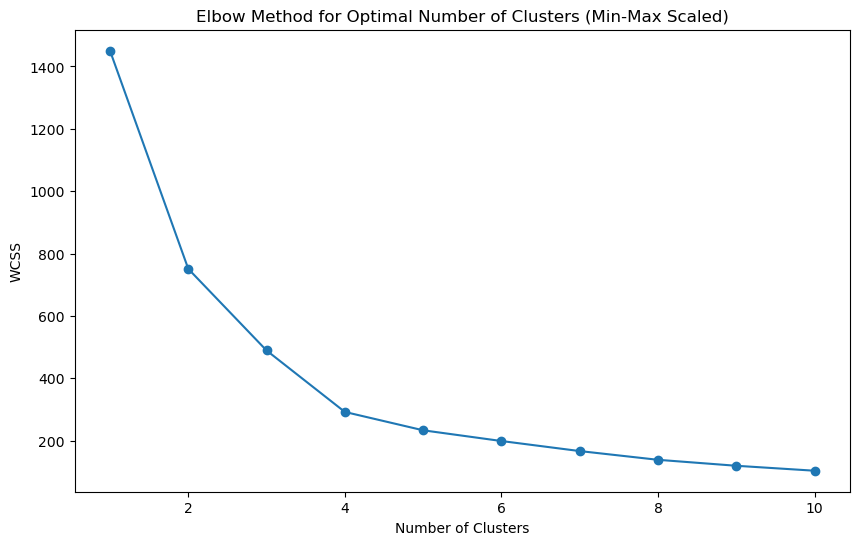

Saved Elbow Method plot: C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main\Clustering_Analysis\optimal_clusters\elbow_method_min-max_scaled.png


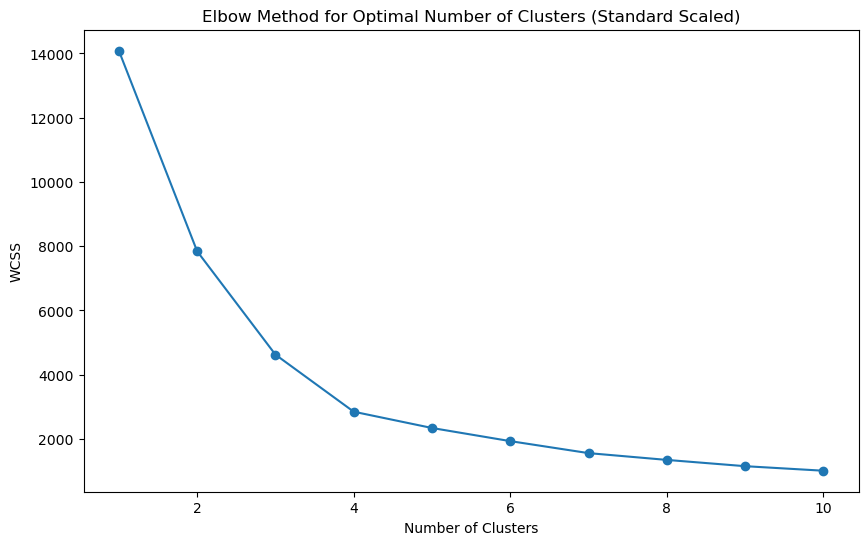

Saved Elbow Method plot: C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main\Clustering_Analysis\optimal_clusters\elbow_method_standard_scaled.png


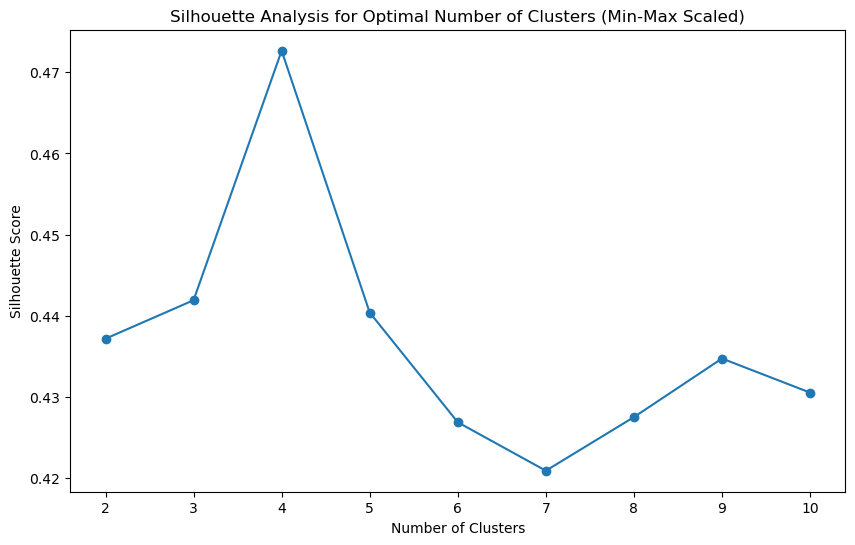

Saved Silhouette Analysis plot: C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main\Clustering_Analysis\optimal_clusters\silhouette_analysis_min-max_scaled.png


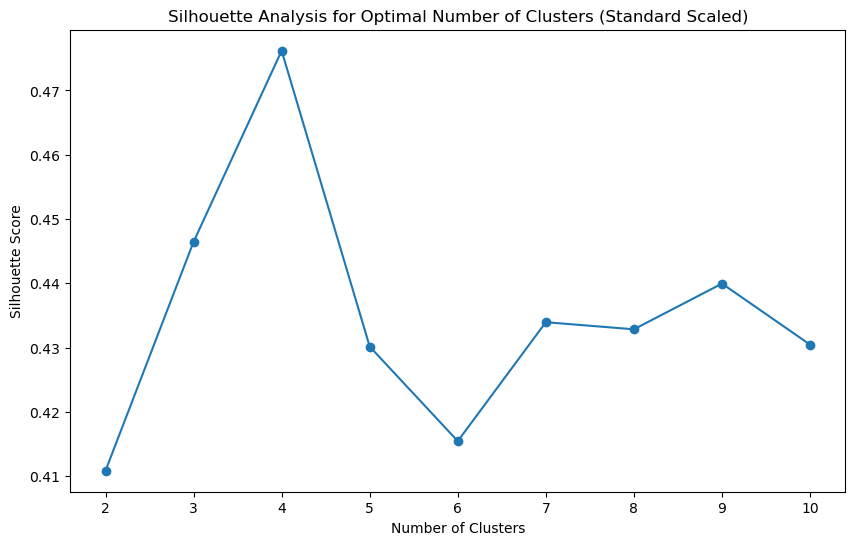

Saved Silhouette Analysis plot: C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main\Clustering_Analysis\optimal_clusters\silhouette_analysis_standard_scaled.png


In [21]:
# Apply the Elbow Method and Silhouette Analysis to determine the optimal number of clusters for both datasets
determine_optimal_clusters(df_min_max_scaled, 'Min-Max Scaled')
determine_optimal_clusters(df_standard_scaled, 'Standard Scaled')
determine_optimal_clusters_with_silhouette(df_min_max_scaled, 'Min-Max Scaled')
determine_optimal_clusters_with_silhouette(df_standard_scaled, 'Standard Scaled')


## Step 6: Interpretation and Choosing the Optimal Number of Clusters
After generating and visualizing the plots for both the Min-Max scaled data and the Standard scaled data, we observed that the plots for each method (Elbow Method and Silhouette Analysis) look very similar across both scaling techniques. This suggests that the scaling method does not significantly impact the determination of the optimal number of clusters in this case. Here's the combined interpretation:

### Elbow Method Interpretation:
 The Elbow Method plots for both the Min-Max scaled data and the Standard scaled data display a noticeable "elbow" at 4 clusters. This indicates that 4 clusters provide a good balance between the compactness of clusters (measured by WCSS) and the simplicity of the model. Beyond 4 clusters, the decrease in WCSS starts to taper off, meaning that adding more clusters would only marginally improve the compactness while increasing the model's complexity.
### Silhouette Analysis Interpretation:
The Silhouette Analysis plots for both scaling methods also show that the Silhouette Score peaks at 4 clusters. This peak suggests that 4 clusters provide the most cohesive and well-separated grouping of data points. A higher Silhouette Score indicates that the clusters are distinct and well-defined, with data points being closer to their own cluster's centroid compared to other clusters.

## Summary:
Optimal Number of Clusters: The Elbow Method and Silhouette Analysis consistently indicate that 4 is the optimal number of clusters for both the Min-Max scaled data and the Standard scaled data.
- Reasoning:
Elbow Method: The "elbow" at 4 clusters shows that this is the point where the within-cluster sum of squares (WCSS) starts to decrease more slowly, indicating diminishing returns with additional clusters.
Silhouette Analysis: The peak Silhouette Score at 4 clusters confirms that the clustering is both strong and meaningful, with well-separated clusters.

## Conclusion
- Based on the Elbow Method and Silhouette Analysis, the optimal number of clusters for this dataset is 4, regardless of whether Min-Max scaling or Standard scaling is applied. The consistency across both scaling methods suggests that the natural grouping within the data is robust to the type of scaling used.

- Application: With 4 clusters identified, you can now proceed to label the clusters, analyze their characteristics, and apply these insights to areas such as customer segmentation, marketing strategies, or targeted interventions.
Efficiency: By noting the similarity in the results between the two scaling methods, you can streamline future analyses by focusing on a single scaling approach if desired.

# Clustering Analysis - Train the Clustering model and interpret results

In this notebook, we will continue our customer segmentation analysis by fitting the K-Means clustering model. Previously, we determined that the optimal number of clusters is 4 based on the Elbow Method and Silhouette Analysis. Our goals in this notebook are:
- **Fit the K-Means model:** Segment customers into 4 clusters using their tenure and monthly charges.
- **Analyze the clusters:** Understand the characteristics of each cluster to gain insights into customer behavior.
- **Save and document the results:** Ensure that the results are stored and documented for future reference and decision-making..

## Step 1: Fitting the K-Means Model and Applying It to the Datasets

**Purpose:**  
In this step, we will fit the K-Means clustering algorithm to our customer datasets and apply it to both the Min-Max scaled and Standard scaled datasets. By clustering the customers into 4 groups, we aim to identify segments based on their tenure and monthly charges. This will help us understand the natural groupings within the data.

**Role of the Code:**  
The function `fit_kmeans_and_analyze` will apply the K-Means algorithm to the datasets. It will assign each customer to one of the 4 clusters, save the results to a file, and update our configuration file to include the path to these results. We will call this function twice: once for the Min-Max scaled data and once for the Standard scaled data. This ensures that we generate clusters for both versions of our dataset and understand how clustering works across different scaling methods.

**Expected Outcome:**  
After running this code, both datasets will have an additional column that indicates the cluster each customer belongs to. The cluster assignments will be saved in CSV files for both the Min-Max scaled and Standard scaled datasets, and the paths to these files will be updated in our configuration file.



In [22]:
# Utility function to convert absolute path to relative path
def to_relative_path(absolute_path, start_path):
    return os.path.relpath(absolute_path, start=start_path).replace('\\', '/')

# Function to fit KMeans and analyze clusters
def fit_kmeans_and_analyze(df, scaling_label):
    # Fit the KMeans model with 4 clusters
    kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42)
    df['Cluster'] = kmeans.fit_predict(df[['tenure', 'MonthlyCharges']])
    
    # Display the first few rows with cluster assignments
    print(f"{scaling_label} Dataset with Cluster Assignments:")
    print(df.head())
    
    # Ensure the correct paths for saving results
    kmeans_model_path = os.path.join(project_root, 'Clustering_Analysis', 'kmeans_model')
    os.makedirs(kmeans_model_path, exist_ok=True)
    
    # Save the DataFrame with cluster assignments
    result_filename = f'{scaling_label.lower().replace(" ", "_")}_4_clusters.csv'
    result_filepath = os.path.join(kmeans_model_path, result_filename)
    df.to_csv(result_filepath, index=False)
    print(f'Saved cluster assignments to: {result_filepath}')
    
    # Update the config file with the new path for cluster assignments
    relative_result_filepath = to_relative_path(result_filepath, project_root)
    config[f'{scaling_label.lower().replace(" ", "_")}_4_clusters_path'] = relative_result_filepath

    with open(config_path, 'w') as f:
        json.dump(config, f, indent=4)
    print(f"Updated config.json with new path for {scaling_label} cluster assignments.")
    


In [23]:
# Perform clustering analysis on both datasets
fit_kmeans_and_analyze(df_min_max_scaled, 'Min-Max Scaled')
fit_kmeans_and_analyze(df_standard_scaled, 'Standard Scaled')

Min-Max Scaled Dataset with Cluster Assignments:
   SeniorCitizen    tenure  MonthlyCharges  gender_Female  gender_Male  \
0            0.0  0.013889        0.115423            1.0          0.0   
1            0.0  0.472222        0.385075            0.0          1.0   
2            0.0  0.027778        0.354229            0.0          1.0   
3            0.0  0.625000        0.239303            0.0          1.0   
4            0.0  0.027778        0.521891            1.0          0.0   

   Dependents_No  Dependents_Yes  PhoneService_No  PhoneService_Yes  \
0            1.0             0.0              1.0               0.0   
1            1.0             0.0              0.0               1.0   
2            1.0             0.0              0.0               1.0   
3            1.0             0.0              1.0               0.0   
4            1.0             0.0              0.0               1.0   

   MultipleLines_No  MultipleLines_Yes  InternetService_DSL  \
0               

## Step 2: Analyzing Cluster Characteristics

We will use the `analyze_and_save_cluster_characteristics` function to calculate statistics (mean, median, std) for tenure and charges within each cluster. This will help us understand customer segments. The results will be saved as CSV files for both datasets.



In [24]:
def analyze_and_save_cluster_characteristics(df, scaling_label):
    # Ensure the correct paths for saving results
    kmeans_model_path = os.path.join(project_root, 'Clustering_Analysis', 'kmeans_model')
    os.makedirs(kmeans_model_path, exist_ok=True)
    
    # Analyze the cluster characteristics
    cluster_characteristics = df.groupby('Cluster').agg({
        'tenure': ['mean', 'median', 'std'],
        'MonthlyCharges': ['mean', 'median', 'std']
    })
    print(f"\nCluster Characteristics ({scaling_label}):")
    print(cluster_characteristics)
    
    # Save the cluster characteristics
    characteristics_filename = f'{scaling_label.lower().replace(" ", "_")}_cluster_characteristics.csv'
    characteristics_filepath = os.path.join(kmeans_model_path, characteristics_filename)
    cluster_characteristics.to_csv(characteristics_filepath)
    print(f'Saved cluster characteristics to: {characteristics_filepath}')
    
    # Update the config file with the new path for cluster characteristics
    relative_characteristics_filepath = to_relative_path(characteristics_filepath, project_root)
    config[f'{scaling_label.lower().replace(" ", "_")}_cluster_characteristics_path'] = relative_characteristics_filepath

    with open(config_path, 'w') as f:
        json.dump(config, f, indent=4)
    print(f"Updated config.json with new path for {scaling_label} cluster characteristics.")


In [25]:
# Analyze and save characteristics for both datasets
analyze_and_save_cluster_characteristics(df_min_max_scaled, 'Min-Max Scaled')
analyze_and_save_cluster_characteristics(df_standard_scaled, 'Standard Scaled')



Cluster Characteristics (Min-Max Scaled):
           tenure                     MonthlyCharges                    
             mean    median       std           mean    median       std
Cluster                                                                 
0        0.750913  0.750000  0.169573       0.157445  0.068657  0.155106
1        0.143104  0.111111  0.126619       0.138631  0.067910  0.134705
2        0.208383  0.180556  0.154481       0.625509  0.615920  0.125690
3        0.818671  0.847222  0.153103       0.742943  0.759701  0.140429
Saved cluster characteristics to: C:\Users\kusha\OneDrive\Documents\Customer-Churn-Analysis-main\Clustering_Analysis\kmeans_model\min-max_scaled_cluster_characteristics.csv
Updated config.json with new path for Min-Max Scaled cluster characteristics.

Cluster Characteristics (Standard Scaled):
           tenure                     MonthlyCharges                    
             mean    median       std           mean    median       std
Clust

# Summary

| **Cluster**                                    | **Min-Max Scaled** | **Standard Scaled** | **Characteristics**                                                                                      |
|------------------------------------------------|--------------------|---------------------|-----------------------------------------------------------------------------------------------------------|
| **High Tenure, High Charges (Premium Customers)** | Cluster 2           | Cluster 1            | Long-term, high-value customers likely subscribed to premium plans. Crucial for retention and upselling opportunities. |
| **Low Tenure, Low Charges (New or Basic Customers)** | Cluster 3           | Cluster 0            | New or lower-value customers. Prime targets for engagement strategies aimed at increasing value through promotions and upsell opportunities. |
| **High Tenure, Low Charges (Loyal but Economical Customers)** | Cluster 0           | Cluster 3            | Loyal customers who have opted for more economical plans over time. Potential to increase lifetime value through premium services or rewards. |
| **Moderate Tenure and Charges (Mid-Tier Customers)** | Cluster 1           | Cluster 2            | Mid-tier customers with stable tenure and charges. Potential for growth through targeted marketing and value-added services. |


## Next Steps:
Develop visualizations to aid in the interpretation of clustering results. Use tools such as Matplotlib or Seaborn to create visual representations of the clusters. These visualizations will help in identifying patterns and trends within the clusters, making it easier to derive actionable insights from the analysis.